In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 8, 4

import sys;import os;
module_path = os.path.abspath(os.path.join('..')).split('PythonCode')[0]+'PythonCode'
if module_path not in sys.path: sys.path.append(module_path+"/")
    
import Plib.ML.Models as ml
import Plib.Signals.TAnalysis as ta
import Plib.Signals.Filters as flt
import pickle

import warnings
warnings.filterwarnings("ignore")
 

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
fname='goldReg.pickle'
with open(fname, 'rb') as handle:
    data = pickle.load(handle) 

#Aligna data in sdata
min_data=[]
for k in data.keys(): min_data.append(data[k].index.min())
d1=str(max(min_data)) 
max_data=[]
for k in data.keys(): max_data.append(data[k].index.max())
d2=str(min(max_data)) 
sdata={}
for k in data.keys():
    df=data[k]
    df=df[(df.index>=d1) & (df.index<=d2)]
    sdata[k]=df 

### Class definition for strategy

In [3]:
class MLTXGB(ml.XGB): #ml.XGB
                
    @staticmethod
    def fs_generation(df,l_rets=[3,15,30],w_sma=[3,15,60],drop_nan=True):
        d1=ta.getVolumeGap(df)
        d1=ta.getDailyChange(d1)
        d1=ta.getOpenSpread(d1)
        d1=ta.getLaggedRets(d1,periods=l_rets)
        d1=ta.getSMAs(d1,periods=w_sma)
        d1=ta.getMarketUpDown(d1)
        fast=min(w_sma)
        d1=ta.getSMACorr(d1,lbl_sma='sma_'+str(fast))
        nan_index=max(max(w_sma),max(l_rets))
        if drop_nan:
            d1=d1[nan_index:]
            d1=d1.dropna()
        features=[c for c in d1.columns if c not in ['Open','High','Low','Close','Adjusted_close','Volume','MarketUpDown_Close1day']]
        return d1,list(features)
    
    @staticmethod
    def makeStudy(df,features=[],regrnd1='',test_periods=252,split=0.85,table=False):
        df=df[:-test_periods].copy()
        df1 = MLTXGB.scaling(df[[*([regrnd1]+features)]],params={'method':'minmax','exclude':[]})
        stats = MLTXGB.gradientBoostingClassifier(df1,regrnd1,t = split,table=table)
        return stats



### Data and plot

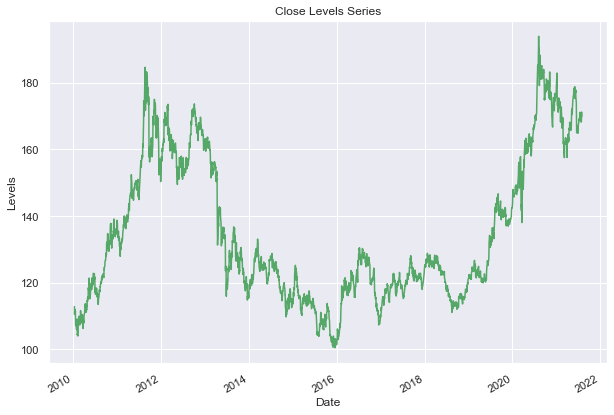

In [4]:
# Instantiate Linreg algo
algo=MLTXGB(rnds=5)

# Select data
gold = sdata['gld_etf']

# Clean data
gold= algo.cleanData(gold)

# Create Features
gold,features=algo.fs_generation(gold)

# Plot the closing price of GLD 11 
algo.plotLevels(gold, benchmark_level='Close')

### Test and Diagnostics

------------------------------------------
Accuracy [0.5159 0.5159]
Recall [0.2479 0.7258]
MCC -0.0298
Specificity [0.7258 0.2479]
F1_score [0.3102 0.6272]
Cohens Kappa -0.0276
------------------------------------------


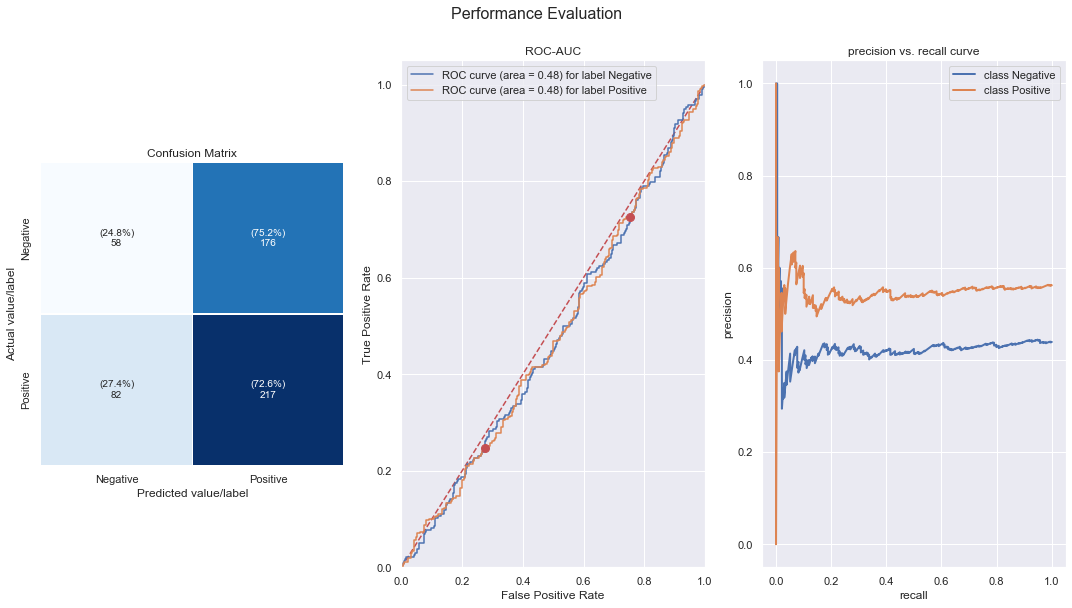

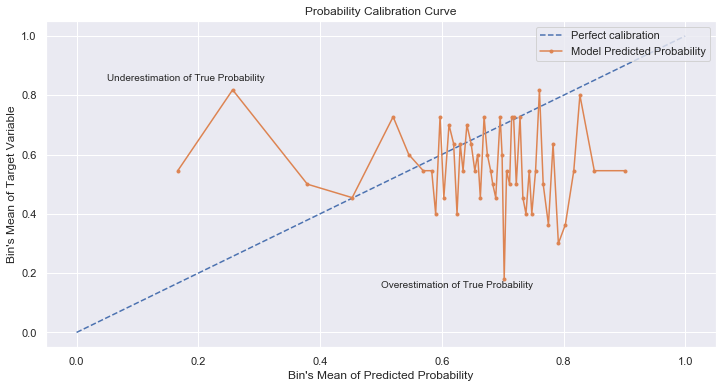

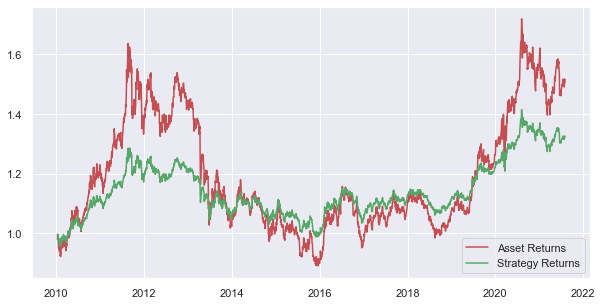

In [5]:
test_periods=252
split=0.8
regrnd1='MarketUpDown_Close1day'
gold_scaled = algo.scaling(gold[[*([regrnd1]+features)]],params={'method':'minmax','exclude':[]})

ret=algo.makeStudy(gold,features,regrnd1,
                        test_periods=test_periods,
                        split=split,table=True)

strategy=algo.applySignal(gold,algo.getProbs(ret['model'],gold_scaled,features),benchmark_level='Close')

algo.plotReturns(strategy)


### Test

Start:  2020-07-30
End:  2021-07-28


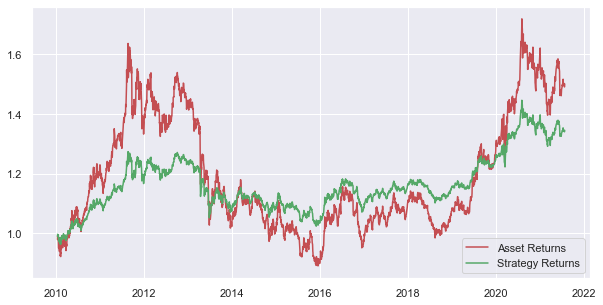

In [8]:
test_periods=252
regrnd1='MarketUpDown_Close1day'

# Strategy data
strategy=gold[:int(len(gold[:-test_periods]))].copy()
gold_scaled = algo.scaling(gold[[*([regrnd1]+features)]],params={'method':'minmax','exclude':[]})
ret=algo.makeStudy(gold,features,regrnd1='MarketUpDown_Close1day',
                            test_periods=test_periods,
                            split=0.75,table=False)

# Test the strategy dy-by-day
print('Start: ', str(strategy.tail(1).index.date[0]))
for d in range(1,test_periods-1):
    last_day=algo.applySignal(gold[:-test_periods+d],algo.getProbs(ret['model'],gold_scaled[:-test_periods+d],features),benchmark_level='Close').iloc[-1]
    strategy=strategy.append(last_day)
print('End: ', str(strategy.tail(1).index.date[0]))

algo.plotReturns(strategy)


### Features Selection

In [19]:
test_periods=252
gold_study=gold[:-test_periods].copy()
features_set=['sma_3','sma_15','sma_60','volumeGap_','dailyChange_','OD_','OL_',
 'lagRets_3','lagRets_15','lagRets_30','corr_sma_3']

d1,d2=algo.fs_analysis(gold_study[[*features]])


Features with Lowest Variance volumeGap_ dailyChange_ OD_ OL_ fractHigh_ fractLow_ sma_15 corr_sma_3 LowVar 
 
 count 
 2666.000000 
 2666.000000 
 2666.000000 
 2666.000000 
 2666.000000 
 2666.000000 
 2666.000000 
 2666.000000 
 
 
 mean 
 0.000000 
 0.000000 
 0.000100 
 -0.002500 
 0.000000 
 0.000000 
 0.577400 
 0.003500 
 
 
 std 
 0.002100 
 0.000000 
 0.005700 
 0.004900 
 0.000000 
 0.000000 
 0.005800 
 0.000900 
 
 
 min 
 -0.008300 
 -0.000200 
 -0.048500 
 -0.049300 
 0.000000 
 0.000000 
 0.553900 
 -0.001600 
 
 
 25% 
 -0.001400 
 -0.000000 
 -0.002900 
 -0.004700 
 0.000000 
 0.000000 
 0.574000 
 0.002900 
 
 
 50% 
 -0.000100 
 0.000000 
 0.000200 
 -0.002100 
 0.000000 
 0.000000 
 0.577300 
 0.003500 
 
 
 75% 
 0.001300 
 0.000000 
 0.003200 
 0.000200 
 0.000000 
 0.000000 
 0.580900 
 0.004200 
 
 
 max 
 0.008300 
 0.000200 
 0.042200 
 0.026500 
 0.000200 
 0.000200 
 0.598600 
 0.005300 
 
            Features with Lowest Correlation volumeGap_ dailyChange_ OD_ lagRets_3 lagRets_15 sma_3 corr_sma_3 
 
 count 
 2666.000000 
 2666.000000 
 2666.000000 
 2666.000000 
 2666.000000 
 2666.000000 
 2666.000000 
 
 
 mean 
 0.000000 
 0.000000 
 0.027000 
 0.071200 
 0.338900 
 131.085700 
 0.775500 
 
 
 std 
 0.467400 
 0.006600 
 1.358800 
 1.692900 
 3.718100 
 18.592500 
 0.168200 
 
 
 min 
 -1.642900 
 -0.051400 
 -12.650000 
 -12.895500 
 -15.414800 
 101.576700 
 -0.308800 
 
 
 25% 
 -0.322400 
 -0.003000 
 -0.620000 
 -0.888100 
 -1.895200 
 117.734200 
 0.682600 
 
 
 50% 
 -0.025000 
 0.000000 
 0.040000 
 0.080700 
 0.294100 
 124.583300 
 0.815300 
 
 
 75% 
 0.295200 
 0.003000 
 0.710000 
 1.024600 
 2.674200 
 142.509200 
 0.908500 
 
 
 max 
 1.719000 
 0.053400 
 10.825000 
 11.127200 
 17.036500 
 184.213300 
 0.995900

In [10]:
test_periods=252
gold_study=gold[:-test_periods].copy()
regrnd1='MarketUpDown_Close1day'

min_features=['sma_3','sma_15','sma_60',]
add_features=['volumeGap_','dailyChange_','OD_','OL_',
 'lagRets_3','lagRets_15','lagRets_30','corr_sma_3']

model=algo.gradientBoostingClassifier
xparams={'n_est':30, 'md':6,'mss':2,'msl':1,'mds':0,'obj':'binary:logistic','em':'auc','lr':0.3,'il':[]}
params=[xparams, False]
df=algo.scaling(gold_study[[*([regrnd1]+min_features+add_features)]],params={'method':'minmax','exclude':[]})
features_comb=algo.fs_combin(df,min_features,regrnd1,add_features,model,params)
print(features_comb)

['sma_3', 'sma_15', 'sma_60', 'volumeGap_', 'dailyChange_', 'OD_', 'lagRets_15', 'lagRets_30', 'corr_sma_3']


### Model Parameters

Best Solution:  513 ('MarketUpDown_Close1day', 1, {'n_est': 60, 'md': 8, 'mss': 1, 'msl': 0, 'mds': 0, 'obj': 'binary:logistic', 'em': 'auc', 'lr': 0.1, 'il': []}, False)


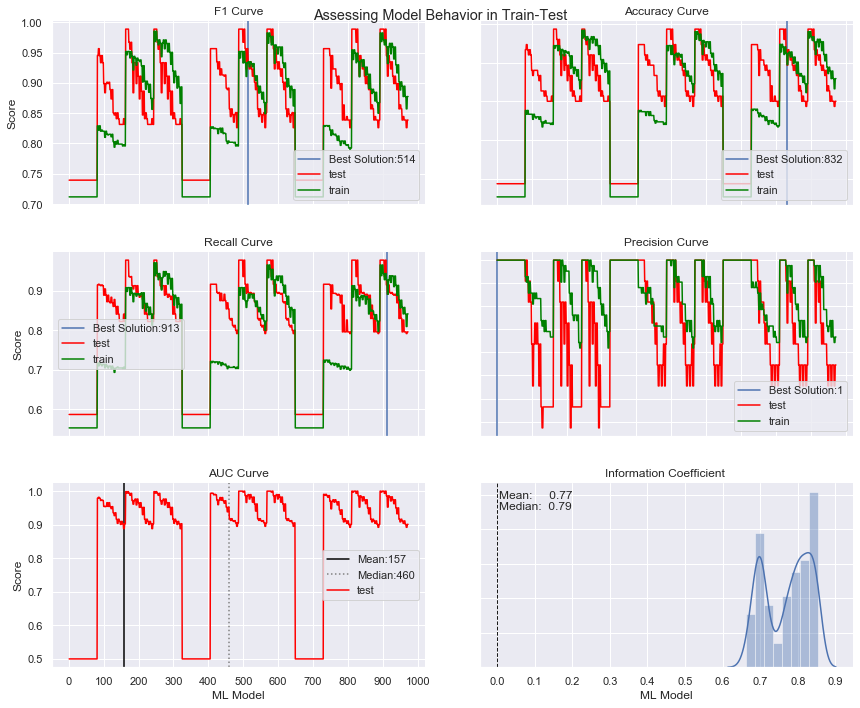

In [20]:
regrnd1='MarketUpDown_Close1day'
model=algo.gradientBoostingClassifier
df=algo.scaling(gold_study[[*([regrnd1]+features_set)]],params={'method':'minmax','exclude':[]})
params=algo.make_params(rg1=regrnd1,n_est=30, md=15, mss=2, mds=2,msl=2,obj='binary:logistic',em='auc',lr=0.3,il=[])
score=algo.md_htDiag(df,regrnd1,model,params,how='awf')
best_param=algo.md_htDiagPlot(score,(12,10))
print('Best Solution: ',best_param, params[best_param])


Best Solution:  0 ('MarketUpDown_Close1day', 1, {'n_est': 60, 'md': 0, 'mss': 0, 'msl': 0, 'mds': 0, 'obj': 'binary:logistic', 'em': 'auc', 'lr': 0.1, 'il': []}, False)


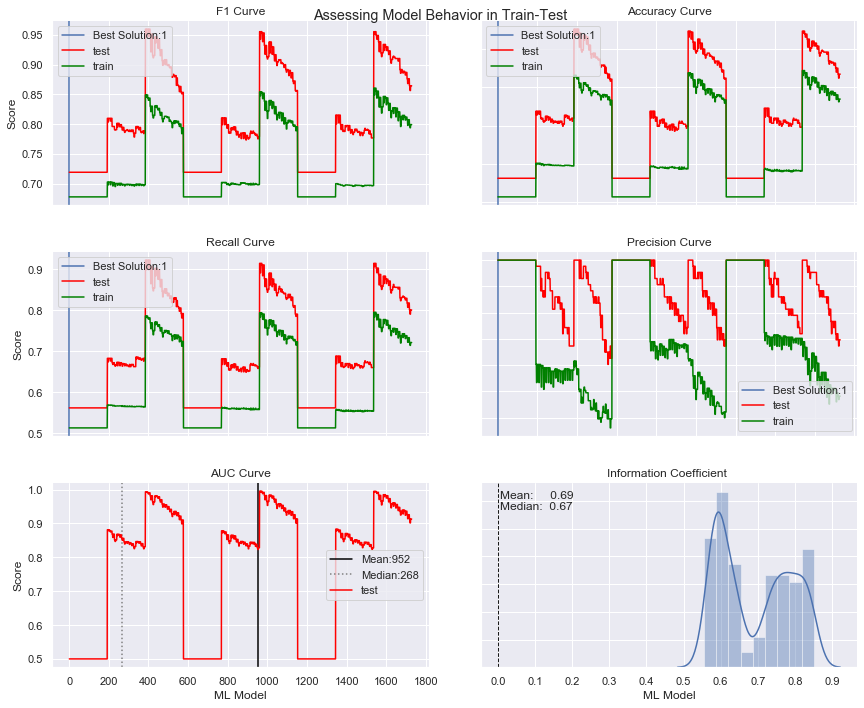

In [22]:
regrnd1='MarketUpDown_Close1day'
model=algo.gradientBoostingClassifier
df=algo.scaling(gold_study[[*([regrnd1]+features_set)]],params={'method':'minmax','exclude':[]})
params=algo.make_params(rg1=regrnd1,n_est=60, md=8, mss=3, mds=3,msl=3,obj='binary:logistic',em='auc',lr=0.3,il=[])
score=algo.md_htDiag(df,regrnd1,model,params,how='cv')
best_param=algo.md_htDiagPlot(score,(12,10))
print('Best Solution: ',best_param, params[best_param])


### Interpretability and Feature Importance with LIME

Explanation Score:  0.11196517254708693


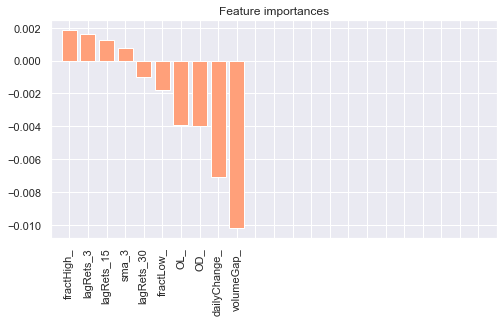

imp
fractHigh_    0.001847
lagRets_3     0.001629
lagRets_15    0.001250
sma_3         0.000751
lagRets_30   -0.000983
fractLow_    -0.001814
OL_          -0.003895
OD_          -0.003997
dailyChange_ -0.007108
volumeGap_   -0.010179

In [23]:
mymodel=ret['model']
lime_gold=algo.scaling(gold,params={'method':'minmax','exclude':[]})

MLTXGB.fs_localInt(lime_gold, features, regrnd1,
                   nclasses=['Up','Down'],
                   which_obs=11,model=mymodel)


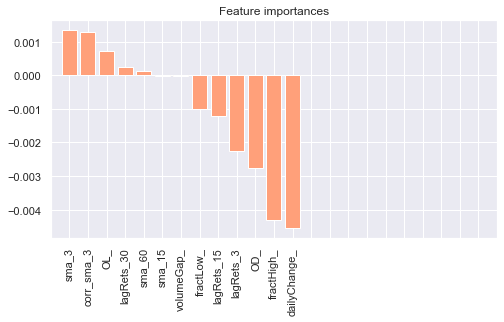

imp
sma_3         0.001342
corr_sma_3    0.001301
OL_           0.000738
lagRets_30    0.000257
sma_60        0.000135
sma_15       -0.000020
volumeGap_   -0.000034
fractLow_    -0.000997
lagRets_15   -0.001214
lagRets_3    -0.002253
OD_          -0.002749
fractHigh_   -0.004294
dailyChange_ -0.004543

In [24]:
MLTXGB.fs_globalInt(lime_gold, features, regrnd1,
                  nclasses=['Up','Down'],ninsta=10, model=mymodel, 
                  mtype='c', test_periods=252)